In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from tqdm.notebook import tqdm

## 1.  Cинтетический Causal Impact без эффекта

In [35]:
# Генерируем синтетические данные с помощью ARMA процесса, где y напрямую зависит от x0
# Также добавим тренд

np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)

seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 30)*3

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0 # x0 - ковариата с трендом
x1 = 55 + arma_process.generate_sample(nsample=1196) # x1 ковариата (не будет скоррелированна)
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y + seasonal_component_monthly # целевая метрика с терндом скоррелированная с ковариатой x0

data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]] # период до treatment
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]] # период после treatment
ts_data.head(10)

,y,x0,x1
2019-01-01,189.447228,100.496714,54.980362
2019-01-02,189.542743,99.766573,55.556418
2019-01-03,192.498641,100.703571,55.112631
2019-01-04,193.004742,101.396530,56.341614
2019-01-05,190.418708,99.505771,54.856902
2019-01-06,191.445845,99.888956,54.599214
2019-01-07,196.233991,101.630686,55.202455
2019-01-08,194.044302,100.475579,55.502807
2019-01-09,191.364107,99.474708,54.948299
2019-01-10,194.457539,100.691933,55.050932


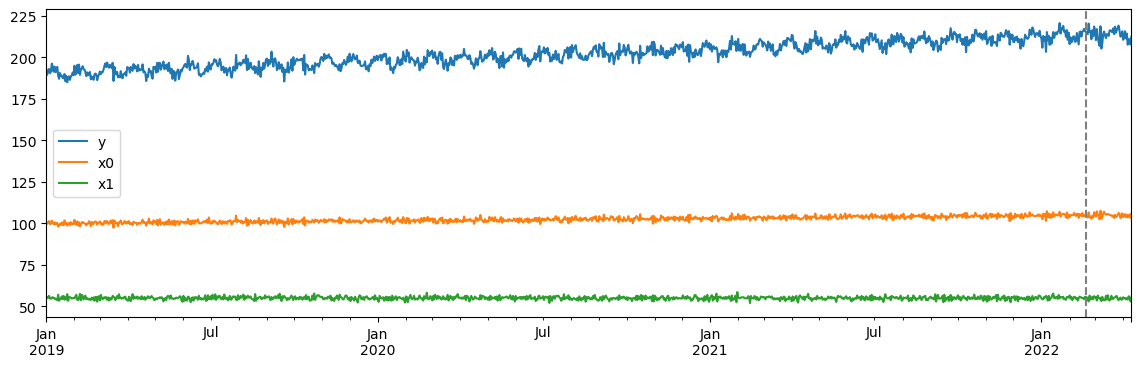

In [36]:
# отрисуем наши переменные
plt.figure(figsize = (14, 4))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
ts_data.x1.plot(label = 'x1')
plt.legend()
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--') # момент гипотетического treatment

In [37]:
# проверим корреляцию рядов
ts_data.corr().style.background_gradient(cmap='coolwarm', axis=None)

,y,x0,x1
y,1.000000,0.902258,-0.021351
x0,0.902258,1.000000,-0.012216
x1,-0.021351,-0.012216,1.000000


<Axes: xlabel='x0', ylabel='y'>

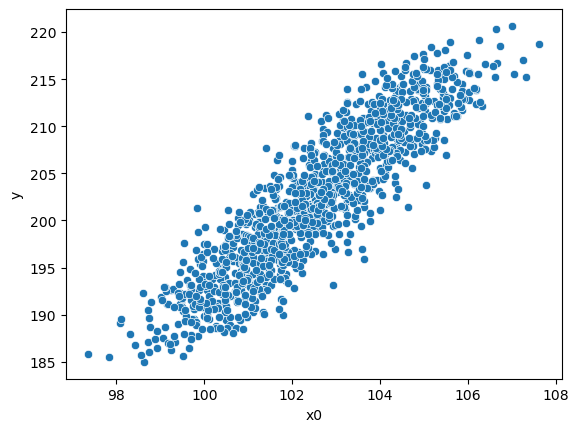

In [38]:
# посмотрим зависимость на графике y и x0
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

<Axes: xlabel='x1', ylabel='y'>

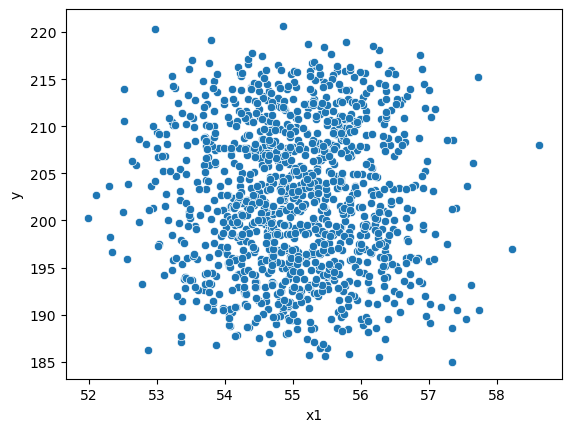

In [39]:
# посмотрим зависимость на графике y и x1
sns.scatterplot(x= ts_data.x1, y = ts_data.y)

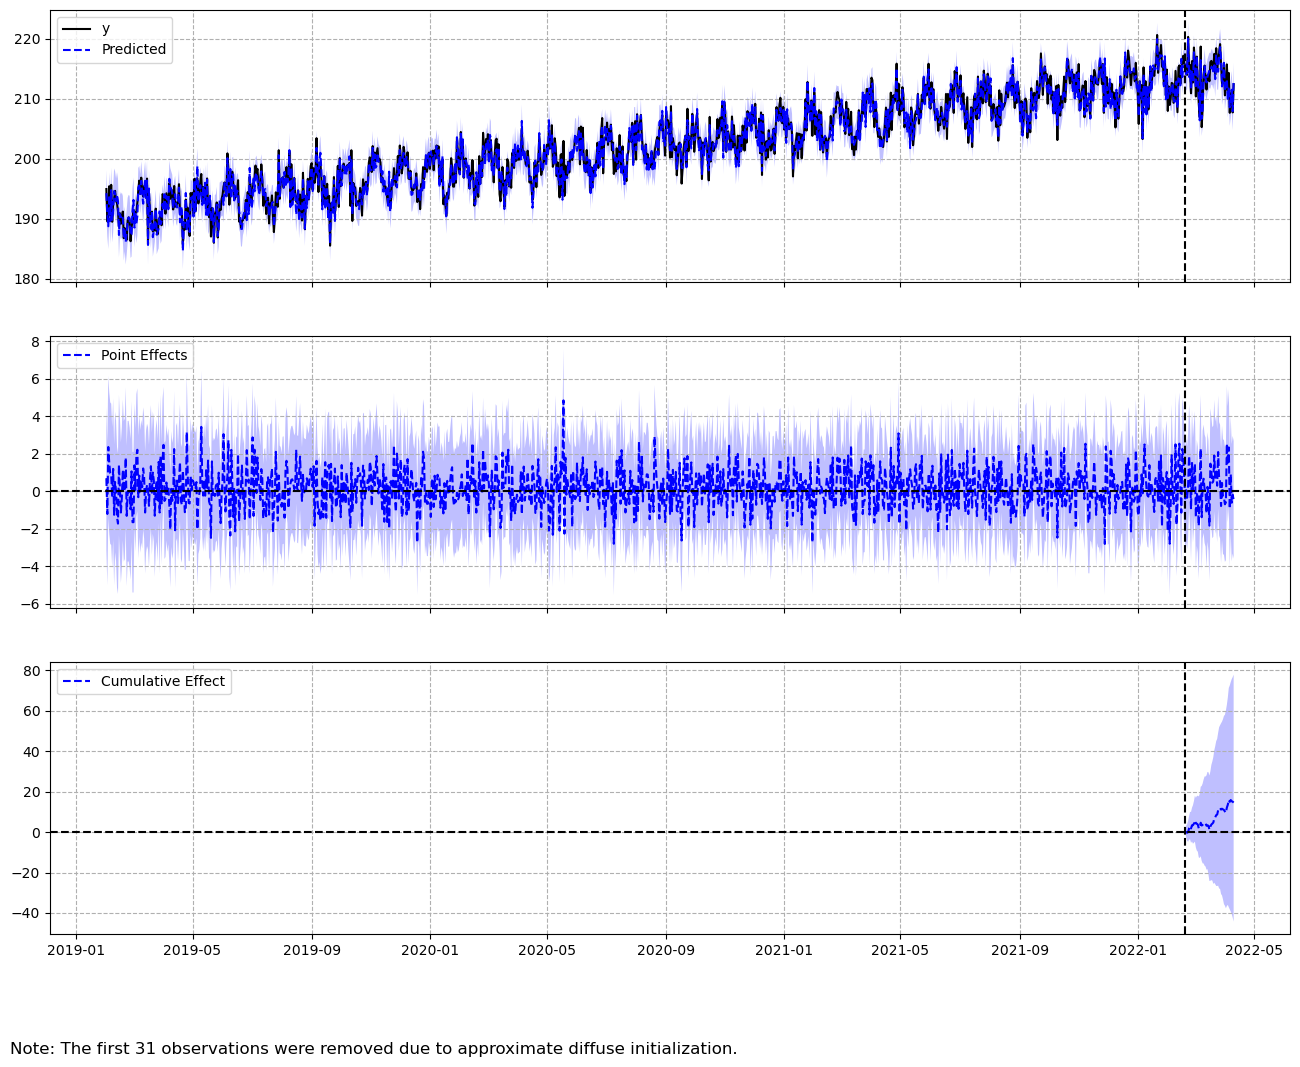

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    213.81             10690.29
Prediction (s.d.)         213.51 (0.47)      10675.69 (23.72)
99% CI                    [212.25, 214.69]   [10612.36, 10734.57]

Absolute effect (s.d.)    0.29 (0.47)        14.6 (23.72)
99% CI                    [-0.89, 1.56]      [-44.28, 77.93]

Relative effect (s.d.)    0.14% (0.22%)      0.14% (0.22%)
99% CI                    [-0.41%, 0.73%]    [-0.41%, 0.73%]

Posterior tail-area probability p: 0.28
Posterior prob. of a causal effect: 72.43%

For more details run the command: print(impact.summary('report'))


In [40]:
# проведем causal impact анализ на данных без эффекта. выведем plot и summary
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01, nseasons=[{'period': 30}])
ci.plot(figsize = (16, 12))
print(ci.summary())

Мы не заложили эффект, что показывает и Causal Impact что изменение -0.09% с 99% доверительным интервалом [-0.45%, 0.26%] и с p-value = 0.26. При порверке гипотезы в Causal Impact, мы проверяем альтернативную гипотезу о том что есть разница против нулевой гипотезы что разницы между метрикой до изменении и после нет. В данном случае p-value = 0.26, мы не можем отвергнуть H0

## 2. Синтетический Causal impact с эффектом
### Давайте попробуем симулировать эффект, добавим +3% с определённого момента

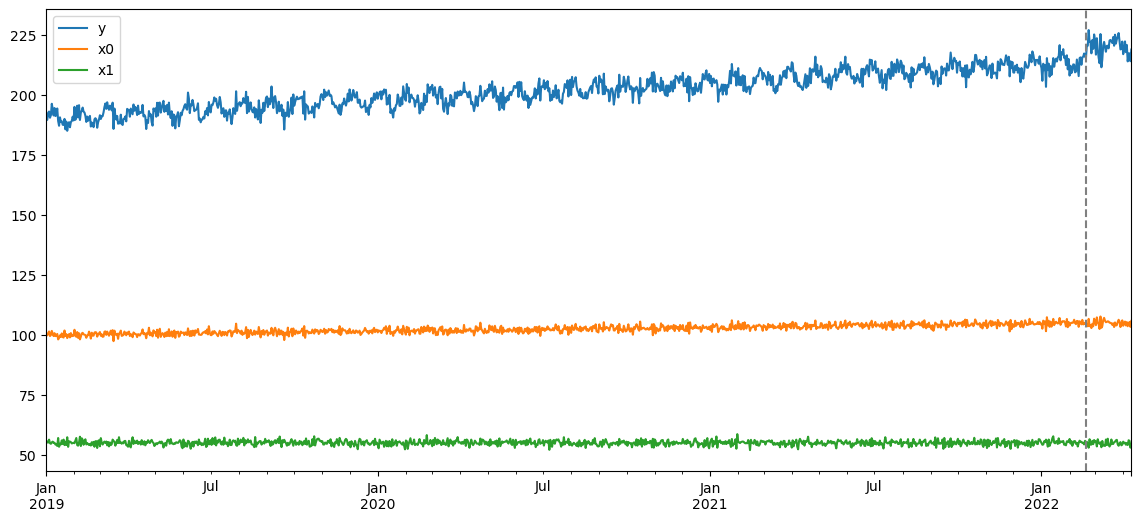

In [75]:
# Генерируем синтетические данные с помощью ARMA процесса, где y напрямую зависит от x0
# Также добавим тренд и сезонность

np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

trend_x0 = np.arange(0, 5, 5/1196) #добавим тренд
trend_y = np.arange(0, 15, 15/1196)


seasonal_component_monthly = np.sin(2 * np.pi * np.arange(1196) / 30)*3

x0 = 100 + arma_process.generate_sample(nsample=1196) + trend_x0 # x0 - ковариата с трендом
x1 = 55 + arma_process.generate_sample(nsample=1196) # x1 ковариата (не будет скоррелированна)
y = 1.9 * x0 + np.random.normal(size=1196) + trend_y + seasonal_component_monthly # целевая метрика с терндом скоррелированная с ковариатой x0

data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

date_range = pd.date_range(start="2019-01-01", periods=1196)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2019-01-01", "2022-02-19"]] # период до treatment
ts_post_period = [pd.to_datetime(date) for date in ["2022-02-20", "2022-04-10"]] # период после treatment

ts_data.loc[ts_post_period[0]:ts_post_period[-1], 'y'] *= 1.03
#ts_data.head(10)

plt.figure(figsize = (14, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
ts_data.x1.plot(label = 'x1')
plt.legend()
plt.axvline(x= '2022-02-19',  color = 'grey', ls = '--')

In [76]:
ts_data

,y,x0,x1
2019-01-01,189.447228,100.496714,54.980362
2019-01-02,189.542743,99.766573,55.556418
2019-01-03,192.498641,100.703571,55.112631
2019-01-04,193.004742,101.396530,56.341614
2019-01-05,190.418708,99.505771,54.856902
...,...,...,...
2022-04-06,213.894857,103.580886,54.091009
2022-04-07,217.221304,104.661552,56.071997
2022-04-08,217.218053,105.371585,55.820850
2022-04-09,213.969635,103.321820,52.989642


In [77]:
# посчитаем корреляцию 
ts_data.loc[:ts_pre_period[-1]].corr().style.background_gradient(cmap='coolwarm', axis=None)

,y,x0,x1
y,1.000000,0.899245,-0.011420
x0,0.899245,1.000000,0.000111
x1,-0.011420,0.000111,1.000000


<Axes: xlabel='x0', ylabel='y'>

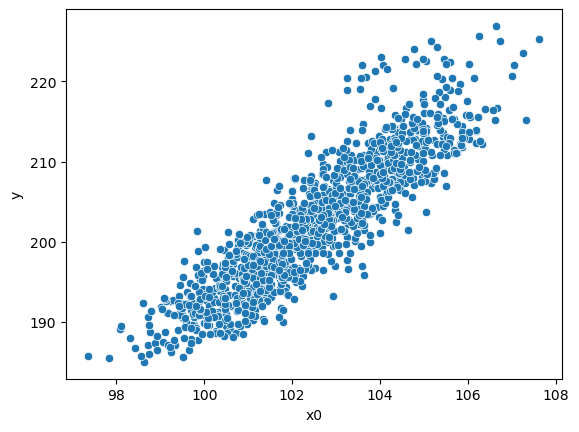

In [78]:
sns.scatterplot(x= ts_data.x0, y = ts_data.y)

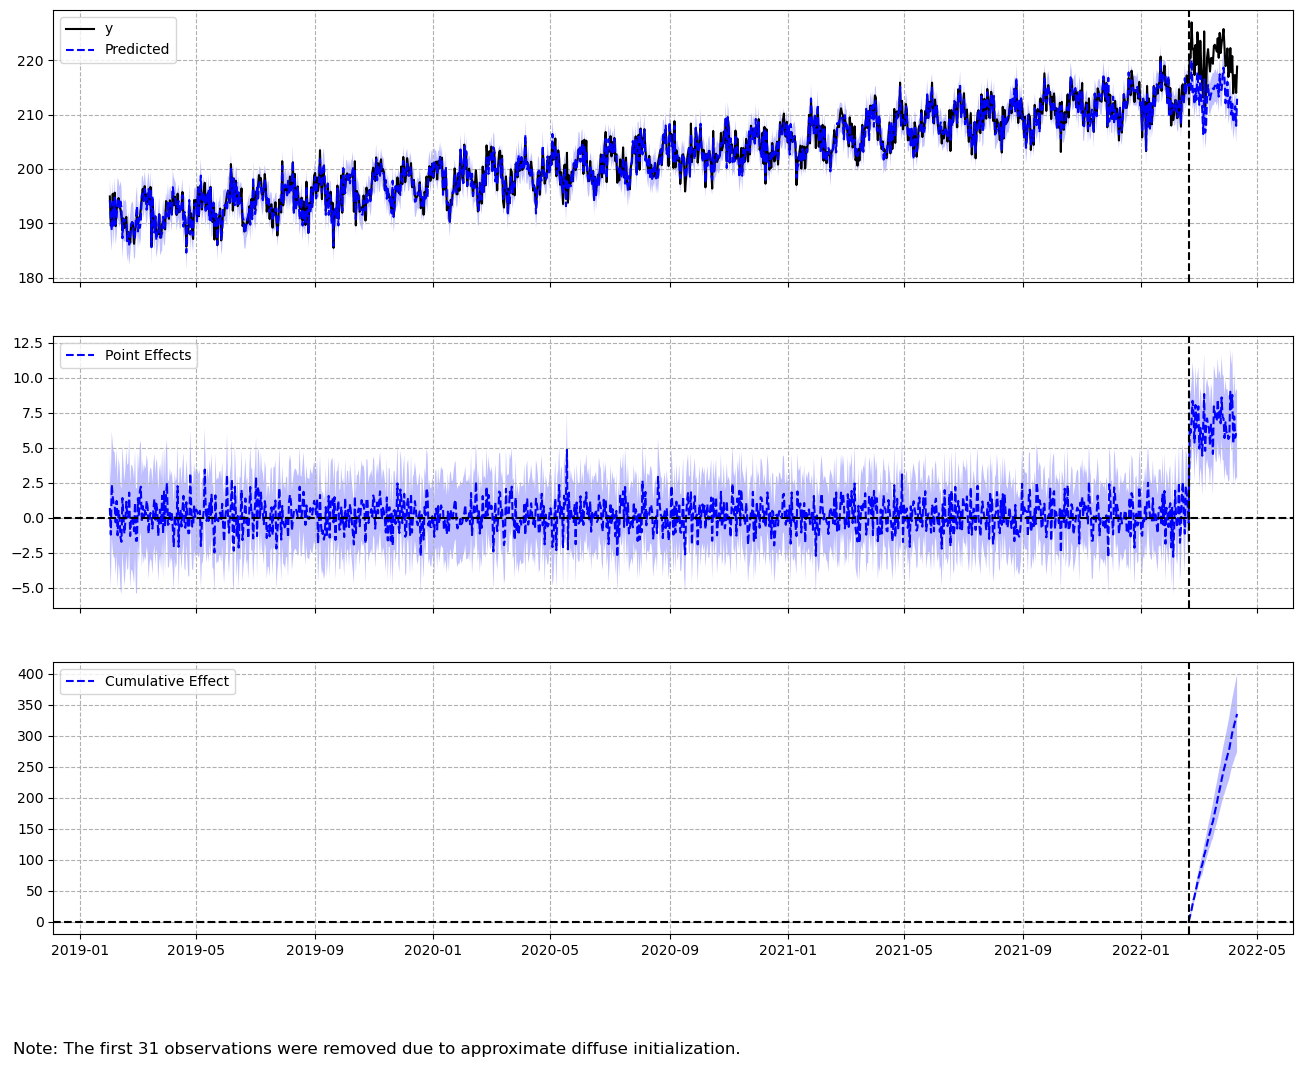

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    220.22             11011.0
Prediction (s.d.)         213.51 (0.48)      10675.69 (24.12)
99% CI                    [212.24, 214.73]   [10612.12, 10736.38]

Absolute effect (s.d.)    6.71 (0.48)        335.31 (24.12)
99% CI                    [5.49, 7.98]       [274.62, 398.88]

Relative effect (s.d.)    3.14% (0.23%)      3.14% (0.23%)
99% CI                    [2.57%, 3.74%]     [2.57%, 3.74%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [89]:
# проведем causal impact анализ на данных с 3% эффектом. выведем plot и summary
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.01, nseasons=[{'period': 30}])
ci.plot(figsize = (16, 12))
print(ci.summary())

Видим что CI нашел  заложенный нами эффект в 3%

## 3. Обращение к summary модели
Бывает полезно обратиться к модели. Давайте рассмотрим несколько методов обращения к объектам

In [101]:
# можно обратится к summary s виде таблицы
ci.summary_data #.loc['rel_effect', 'average']

,average,cumulative
actual,220.219965,11010.998233
predicted,213.513829,10675.691432
predicted_lower,212.242315,10612.115727
predicted_upper,214.727647,10736.382333
abs_effect,6.706136,335.306802
abs_effect_lower,5.492318,274.615900
abs_effect_upper,7.977650,398.882506
rel_effect,0.031408,0.031408
rel_effect_lower,0.025723,0.025723
rel_effect_upper,0.037364,0.037364


In [102]:
# С помощью этого метода можно вызвать общую информацию по регрессионной модели, включая коэффициенты параметров моделей, их стат. значимость, критерий Акаике, Льюнга-Бокса и т.д.
# sigma2.irregular - шум
# sigma2.level - тренд
# sigma2.freq_seasonal_* - сезонный компонент зажанной периодичности *
# beta.x - коэффициент при регрессорах
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1146
Model:                                    local level   Log Likelihood                 558.526
                   + stochastic freq_seasonal(30(15))   AIC                          -1107.053
Date:                                Tue, 05 Mar 2024   BIC                          -1081.970
Time:                                        19:15:35   HQIC                         -1097.570
Sample:                                    01-01-2019                                         
                                         - 02-19-2022                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular                0.0178      0.001     22.119      0.000       0.016       0.019
sigma2.level                    0.0001   4.02e-05      3.348      0.001    5.58e-05       0.000
sigma2.freq_seasonal_30(15)   3.66e-08    7.2e-08      0.508      0.611   -1.05e-07    1.78e-07
beta.x0                         0.4565      0.008     60.401      0.000       0.442       0.471
beta.x1                        -0.0041      0.004     -0.984      0.325      -0.012       0.004
===================================================================================
Ljung-Box (L1) (Q):                   6.63   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.01   Prob(JB):                         0.67
Heteroskedasticity (H):               1.28   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Так же отдельно от общей информации по регрессионной модели, можно отдельно вывести значения Z - статистики (так же можно и T - статистики) по параметрам модели, а так же их p-value значения для проверки на стат. значимость. И доверительные интервалы как нижние, так и верхние

In [103]:
# можно обращаться к z-статистикам проверки значимости коэффициентов в модели
ci.trained_model.zvalues

sigma2.irregular               22.118931
sigma2.level                    3.348353
sigma2.freq_seasonal_30(15)     0.508004
beta.x0                        60.401469
beta.x1                        -0.984111
dtype: float64

In [104]:
# проверка коэффициентов модели на стат значимость
ci.trained_model.pvalues > 0.01

sigma2.irregular               False
sigma2.level                   False
sigma2.freq_seasonal_30(15)     True
beta.x0                        False
beta.x1                         True
dtype: bool

In [105]:
# доверительные интервалы для коэффициентов модели
ci.trained_model.conf_int()

,0,1
sigma2.irregular,1.625024e-02,1.941011e-02
sigma2.level,5.581111e-05,2.133862e-04
sigma2.freq_seasonal_30(15),-1.046125e-07,1.778149e-07
beta.x0,4.416748e-01,4.712998e-01
beta.x1,-1.214276e-02,4.024884e-03


In [106]:
# Этим методом можно посмотреть на предсказанные значения по каждому дню, их доверительные интервалы, разницу между факт.
# и предсказанными значениями, и т.д.
ci.inferences

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
2019-01-01,NaN,198.046571,NaN,NaN,NaN,-76746.584872,77142.678014,NaN,NaN,NaN,-8.599343,-76953.230786,76936.032099,NaN,NaN,NaN
2019-01-02,NaN,196.607225,NaN,NaN,NaN,-76748.024218,77141.238668,NaN,NaN,NaN,-7.064482,-76951.695925,76937.566961,NaN,NaN,NaN
2019-01-03,NaN,197.907953,NaN,NaN,NaN,-76596.293960,76992.109866,NaN,NaN,NaN,-5.409312,-76799.611225,76788.792601,NaN,NaN,NaN
2019-01-04,NaN,199.316191,NaN,NaN,NaN,-76594.885722,76993.518104,NaN,NaN,NaN,-6.311449,-76800.513362,76787.890464,NaN,NaN,NaN
2019-01-05,NaN,195.264841,NaN,NaN,NaN,-76465.959999,76856.489682,NaN,NaN,NaN,-4.846134,-76666.070975,76656.378707,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,10143.781454,208.599789,208.599789,205.485834,211.713744,205.485834,211.713744,9833.356038,9776.436516,9888.336511,5.295068,2.181113,8.409023,310.425417,255.444943,367.344938
2022-04-07,10361.002759,209.996307,209.996307,206.874539,213.118074,206.874539,213.118074,10043.352344,9985.643161,10100.792593,7.224998,4.103230,10.346765,317.650414,260.210165,375.359597
2022-04-08,10578.220811,211.512116,211.512116,208.382686,214.641547,208.382686,214.641547,10254.864460,10195.067589,10312.427229,5.705936,2.576506,8.835367,323.356351,265.793582,383.153222
2022-04-09,10792.190446,207.929426,207.929426,204.792259,211.066593,204.792259,211.066593,10462.793886,10400.597239,10523.269677,6.040209,2.903042,9.177376,329.396560,268.920768,391.593207


## 4. Оценка качества прогноза модели

##### Полезно понимать насколько модель временого ряда хорошо предсказывает на исторических данных
На уже существующих данных, можно попробовать оценить:
- MAE (Mean Absolute Error - Средняя Абсолютная Ошибка)
- MAPE
- R2_score

In [107]:
# Метрики оценки на зафиттенных данных
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.y, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.y, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.y, ci_data_pre.preds)

print('MAE =', round(mae, 3))
#print('MAE =', round(ci_data_pre.point_effects.abs().mean(), 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)

MAE = 0.977
MAPE = 0.005
R2_score = 0.9652407745390212


## 5. Анализ остатков модели

http://www.machinelearning.ru/wiki/index.php?title=%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D0%BE%D1%81%D1%82%D0%B0%D1%82%D0%BA%D0%BE%D0%B2#.D0.A1.D0.B2.D0.BE.D0.B9.D1.81.D1.82.D0.B2.D0.B0_.D1.80.D0.B5.D0.B3.D1.80.D0.B5.D1.81.D1.81.D0.B8.D0.BE.D0.BD.D0.BD.D1.8B.D1.85_.D0.BE.D1.81.D1.82.D0.B0.D1.82.D0.BA.D0.BE.D0.B2

#### Хорошая модель если: 
* Остатки стационарны
* Несмещенность остатков . Мат ожидание остатков = 0
* Неавтокоррелированность остатков. Автокоррелция - это корреляция, проявляющаяся во времени.

**Для проверки этих предположений в causal impact встроены несколько стат критериев**

#### Статистический критерий Дики-Фуллера. Проверка на стационарность
https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0

$\large H_0:$ ряд нестационарен

$\large H_1:$ ряд стационарен

#### Тест Стьюдента (Одновыборочный t - критерий). Проверка на несмещенность остатков относительно 0
$\large H_0: \bar{x} = m$

$\large H_1: \bar{x} \neq m$

Несмещённость - равенство среднего значения нуля

#### Критерий Льюнга-Бокса. Проверка на наличие автокорреляции
https://einsteins.ru/subjects/ekonometrika/teoriya-ekonometrika/ponyatie-i-prichiny-avtokorrelyacii
http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9B%D1%8C%D1%8E%D0%BD%D0%B3%D0%B0-%D0%91%D0%BE%D0%BA%D1%81%D0%B0

$\large H_0:$ остатки неавтокоррелированы

$\large H_1:$ остатки автокоррелированы (underfit)

p-value тест Дики-Фуллера = 0.000000
p-value тест Стьюдента = 0.625201
p-value тест Льюнга-Бокса = 0.010024


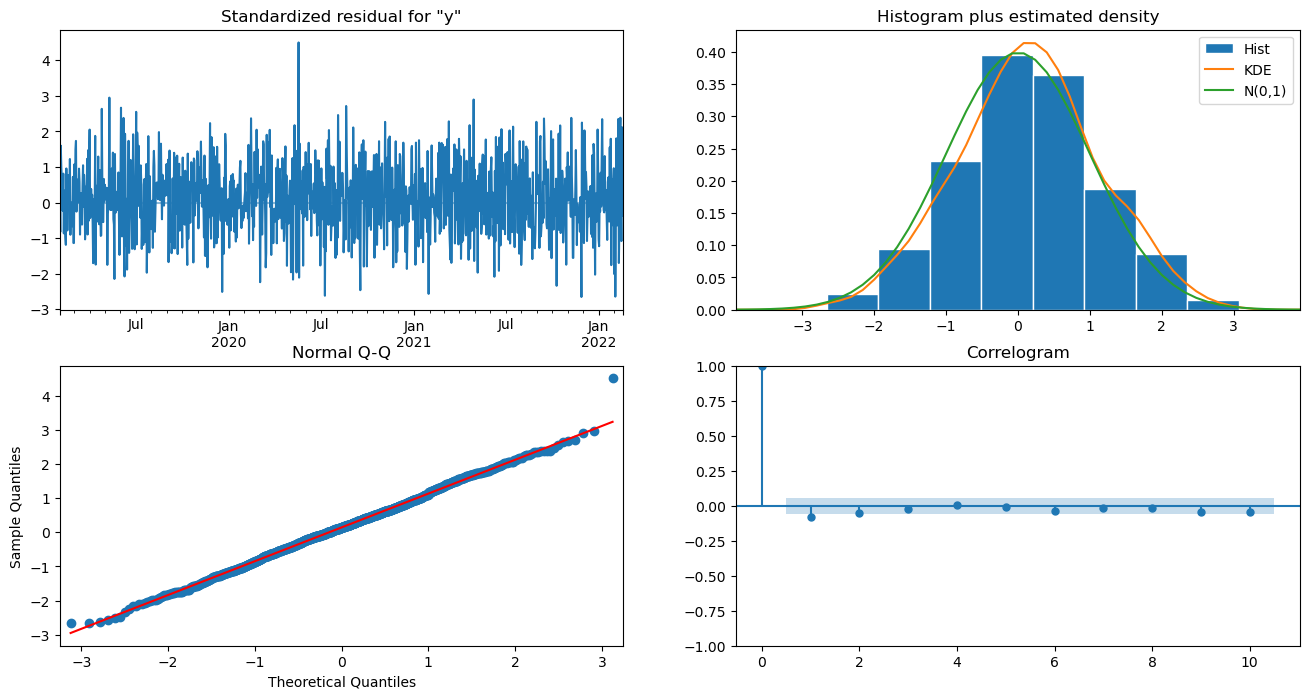

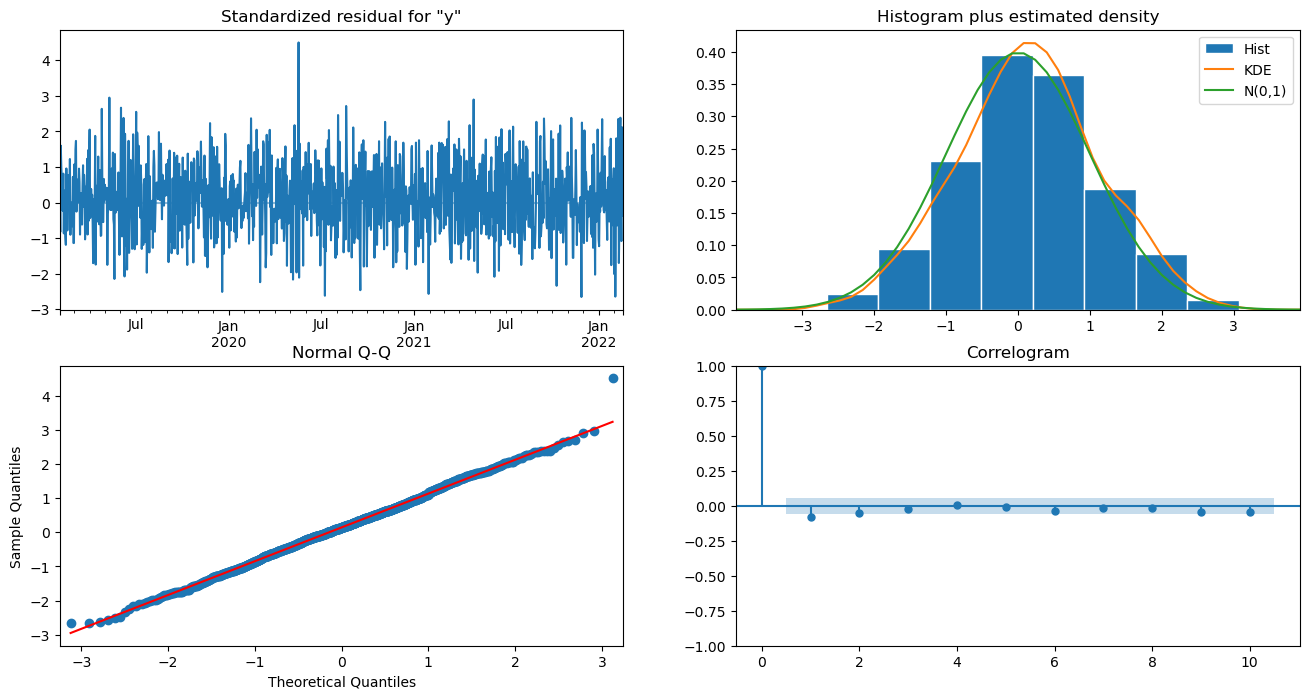

In [108]:
# давайте отпринтуем результаты проверки остатков модели
print("p-value тест Дики-Фуллера = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value тест Стьюдента = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value тест Льюнга-Бокса = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8))

По стат. критерию Дики-Фуллера а так же по графику стандартизированного распределения остатков, можно увидеть что остатки стационарны.

По графику гистограммы распределения остатков, можем наблюдать что остатки несмещены и ср. значение находится близко к нулю. t-test не позволят отвергнуть гипотезу о несмещенности.

По стат. критерию Q-критерия Льюнга-Бокса, гипотеза H0 об отсутствии автокрреляции отвергается. Но по графику коррелограммы, видно что остатки мало автокррелирваонны.